# Week 4: Using real world data

Welcome! So far you have worked exclusively with generated data. This time you will be using the [Daily Minimum Temperatures in Melbourne](https://github.com/jbrownlee/Datasets/blob/master/daily-min-temperatures.csv) dataset which contains data of the daily minimum temperatures recorded in Melbourne from 1981 to 1990. In addition to be using Tensorflow's layers for processing sequence data such as Recurrent layers or LSTMs you will also use Convolutional layers to improve the model's performance.

- All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.

- You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

- You can add the comment # grade-up-to-here in any graded cell to signal the grader that it must only evaluate up to that point. This is helpful if you want to check if you are on the right track even if you are not done with the whole assignment. Be sure to remember to delete the comment afterwards!

- Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.

- To submit your notebook, save it and then click on the blue submit button at the beginning of the page.

Let's get started!

In [1]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
import unittests

Begin by looking at the structure of the csv that contains the data:

In [3]:
DATA_PATH = './data/daily-min-temperatures.csv'

with open(DATA_PATH, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")    
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



As you can see, each data point is composed of the date and the recorded minimum temperature for that date.


In the first exercise you will code a function to read the data from the csv but for now run the next cell to load a helper function to plot the time series.

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    """Plot the series"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

## Parsing the raw data

### Exercise 1: parse_data_from_file

Now you need to read the data from the csv file. To do so, complete the `parse_data_from_file` function.

A couple of things to note:

- You are encouraged to use the function [`np.loadtxt`](https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html) to load the data. Make sure to check out the documentation to learn about useful parameters. 
- The `times` list should contain every timestep (starting at zero), which is just a sequence of ordered numbers with the same length as the `temperatures` list.
- The values of the `temperatures` should be of `float` type. Make sure to select the correct column to read with `np.loadtxt`.

In [37]:
# GRADED FUNCTION: parse_data
def parse_data_from_file(filename):
    """Parse data from csv file

    Args:
        filename (str): complete path to file (path + filename)

    Returns:
        (np.ndarray, np.ndarray): arrays of timestamps and values of the time series
    """    
    ### START CODE HERE
    # Load the temperatures using np.loadtxt. Remember you want to skip the first 
    # row, since it's headers. Make sure to use the correct column of the csv file.
    data = np.loadtxt(filename, delimiter=',', skiprows=1, dtype=str)
    
    # Extract the first column as timestamps and the second as temperatures
    times = np.arange(len(data))  # First column (timestamps)
    temperatures = data[:, 1].astype(float)  # Second column (convert to float)
    ### END CODE HERE
        
    return times, temperatures

Now, use this function to create the timestamps, `TIME`, and the time series, `SERIES`

In [38]:
TIME, SERIES = parse_data_from_file(DATA_PATH)

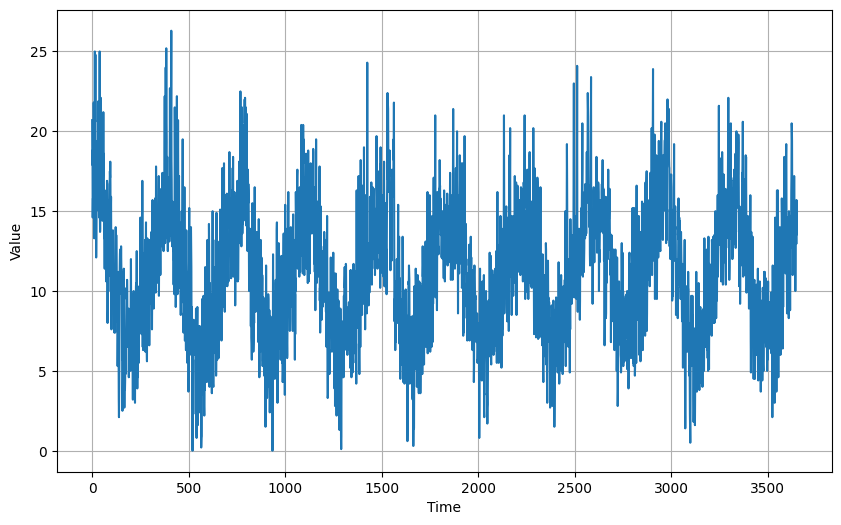

In [39]:
# Plot the series!
plt.figure(figsize=(10, 6))
plot_series(TIME, SERIES)

**Expected Output:**
<div>
<img src="images/temp-series.png" width="650"/>
</div>

In [40]:
# Test your code!
unittests.test_parse_data_from_file(parse_data_from_file)

 All tests passed!


## Defining some useful global variables

Next, you will define some global variables that will come used throughout the assignment. Feel free to reference them in the upcoming exercises:


`SPLIT_TIME`: time index to split between train and validation sets

`WINDOW_SIZE`: length od the window to use for smoothing the series

`BATCH_SIZE`: batch size for training the model

`SHUFFLE_BUFFER_SIZE`: number of elements from the dataset used to sample for a new shuffle of the dataset. For more information about the use of this variable you can take a look at the [docs](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle).

**A note about grading:**

**When you submit this assignment for grading these same values for these globals will be used so make sure that all your code works well with these values. After submitting and passing this assignment, you are encouraged to come back here and play with these parameters to see the impact they have in the classification process. Since this next cell is frozen, you will need to copy the contents into a new cell and run it to overwrite the values for these globals.** 

The next cell will use your function to compute the `times` and `temperatures` and will save these as numpy arrays within the `G` dataclass. This cell will also plot the time series:

In [41]:
# Save all global variables
SPLIT_TIME = 2500
WINDOW_SIZE = 64
BATCH_SIZE = 256
SHUFFLE_BUFFER_SIZE = 1000

## Processing the data

Since you already coded the `train_val_split` and `windowed_dataset` functions during past week's assignments, this time they are provided for you. Notice that like in week 3, the `windowed_dataset` function has an extra step, which expands the series to have an extra dimension. This is done because you will be working with Conv layers which expect the dimensionality of its inputs to be 3 (including the batch dimension).

In [42]:
def train_val_split(time, series):
    """ Splits time series into train and validations sets"""
    time_train = time[:SPLIT_TIME]
    series_train = series[:SPLIT_TIME]
    time_valid = time[SPLIT_TIME:]
    series_valid = series[SPLIT_TIME:]

    return time_train, series_train, time_valid, series_valid

In [43]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)

In [44]:
def windowed_dataset(series, window_size):
    """Creates windowed dataset"""
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(BATCH_SIZE).prefetch(1)
    return dataset

In [45]:
# Apply the transformation to the training set
train_dataset = windowed_dataset(series_train, window_size=WINDOW_SIZE)

## Defining the model architecture

### Exercise 2: create_uncompiled_model

Now that you have a function that will process the data before it is fed into your neural network for training, it is time to define your model architecture. Just as in last week's assignment you will do the layer definition and compilation in two separate steps. Begin by completing the `create_uncompiled_model` function below.

This is done so you can reuse your model's layers for the learning rate adjusting and the actual training.

**Hint:**

- Remember that the original dataset was expanded, so account for this when setting the shape of the `tf.keras.Input`

- No `Lambda` layers are required
- Use a combination of `Conv1D` and `LSTM` layers, followed by `Dense`.

In [48]:
# GRADED FUNCTION: create_uncompiled_model
def create_uncompiled_model():
    """Define uncompiled model

    Returns:
        tf.keras.Model: uncompiled model
    """
    ### START CODE HERE ###
    
    model = tf.keras.models.Sequential([ 
        tf.keras.Input(shape=(WINDOW_SIZE,1)),
        tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal'),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1), 
    ])
    
    ### END CODE HERE ###
    return model

The next cell allows you to check the number of total and trainable parameters of your model and prompts a warning in case these exceeds those of a reference solution, this serves the following 3 purposes listed in order of priority:

- Helps you prevent crashing the kernel during training.

- Helps you avoid longer-than-necessary training times.

- Provides a reasonable estimate of the size of your model. In general you will usually prefer smaller models given that they accomplish their goal successfully.

**Notice that this is just informative** and may be very well below the actual limit for size of the model necessary to crash the kernel. So even if you exceed this reference you are probably fine. However, **if the kernel crashes during training or it is taking a very long time and your model is larger than the reference, come back here and try to get the number of parameters closer to the reference.**

In [49]:
# Get your uncompiled model
uncompiled_model = create_uncompiled_model()

# Check the parameter count against a reference solution
unittests.parameter_count(uncompiled_model)

Your model has 68,575 total parameters and the reference is 60,000
Warning! this exceeds the reference which is 60,000. If the kernel crashes while training, switch to a simpler architecture.

Your model has 68,575 trainable parameters and the reference is 60,000
Warning! this exceeds the reference which is 60,000. If the kernel crashes while training, switch to a simpler architecture.


In [50]:
example_batch = train_dataset.take(1)

try:
	predictions = uncompiled_model.predict(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	print("Your current architecture is compatible with the windowed dataset! :)")
	print(f"predictions have shape: {predictions.shape}")

Your current architecture is compatible with the windowed dataset! :)
predictions have shape: (256, 1)


**Expected output:**

```
Your current architecture is compatible with the windowed dataset! :)
predictions have shape: (NUM_BATCHES, 1)
```
Where `NUM_BATCHES` is the number of batches you have set to your dataset.

In [51]:
# Test your code!
unittests.test_create_uncompiled_model(create_uncompiled_model)

 All tests passed!


You can also print a summary of your model to see what the architecture looks like. This can be useful to get a sense of how big your model is.

In [52]:
uncompiled_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 64, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,575 (267.87 KB)

 Trainable params: 68,575 (267.87 KB)

 Non-trainable params: 0 (0.00 B)

## Adjusting the learning rate - (Optional Exercise)

As you saw in the lectures, you can leverage Tensorflow's callbacks to dinamically vary the learning rate during training. This can be helpful to get a better sense of which learning rate better acommodates to the problem at hand. This is the same function you had on Week 3 Assignment, feel free to reuse it.

**Notice that this is only changing the learning rate during the training process to give you an idea of what a reasonable learning rate is and should not be confused with selecting the best learning rate, this is known as hyperparameter optimization and it is outside the scope of this course.**

For the optimizers you can try out:

- tf.keras.optimizers.Adam
- tf.keras.optimizers.SGD with a momentum of 0.9

In [53]:
def adjust_learning_rate(dataset):
    """Fit model using different learning rates

    Args:
        dataset (tf.data.Dataset): train dataset

    Returns:
        tf.keras.callbacks.History: callback history
    """

    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))
    
    ### START CODE HERE ###
    
    # Select your optimizer
    optimizer = None
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=None,
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    ### END CODE HERE ###

    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [ ]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_dataset)

In [ ]:
plt.semilogx(lr_history.history["learning_rate"], lr_history.history["loss"])

## Compiling the model

### Exercise 3: create_model

Now, it is time to do the actual training that will be used to forecast the time series. For this, complete the `create_model` function below.

Notice that you are reusing the architecture you defined in the `create_uncompiled_model` earlier. Now you only need to compile this model using the appropriate loss, optimizer (and learning rate). If you completed the optional exercise, you should have a better idea of what a good learning rate would be.

**Hints:**

- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.


- If after the first epoch you get an output like this: loss: nan - mae: nan it is very likely that your network is suffering from exploding gradients. This is a common problem if you used SGD as optimizer and set a learning rate that is too high. If you encounter this problem consider lowering the learning rate or using Adam with the default learning rate.

In [54]:
# GRADED FUNCTION: create_model
def create_model():
    """Creates and compiles the model

    Returns:
        tf.keras.Model: compiled model
    """
    
    model = create_uncompiled_model()

    ### START CODE HERE ###

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(momentum=0.9),
                  metrics=["mae"])  
    

    ### END CODE HERE ###

    return model

In [55]:
# Save an instance of the model
model = create_model()

In [56]:
# Test your code!
unittests.test_create_model(create_model)

 All tests passed!


If you passed the unittests, go ahead and train your model by running the cell below:

In [57]:
# Train it
history = model.fit(train_dataset, epochs=50)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 9.0474 - mae: 9.5449
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.1017 - mae: 4.5800
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.9148 - mae: 3.3801
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.8540 - mae: 3.3250
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.7152 - mae: 3.1811
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.5476 - mae: 3.0106
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.3488 - mae: 2.8072
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.3076 - mae: 2.7730
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.0296 - mae: 2.4847
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.7383 - mae: 2.1862
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.7573 - mae: 2.2065
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.6449 - mae: 2.0929
Epoch 13/50
10/10 ━━━━━━━━━━━━━━━━━━━

Now plot the training loss so you can monitor the learning process.

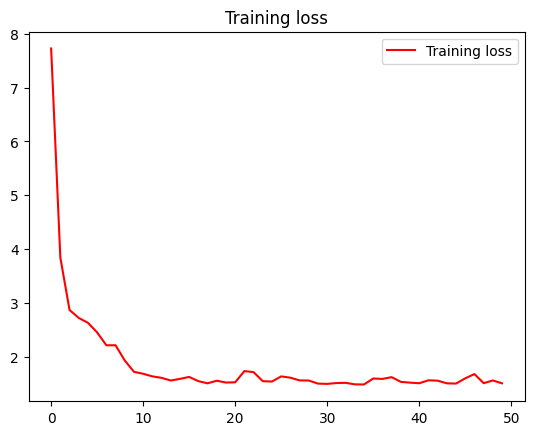

In [58]:
# Plot the training loss for each epoch

loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.show()

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in a previous assignment:

In [59]:
def compute_metrics(true_series, forecast):
    """Computes MSE and MAE metrics for the forecast"""
    mse = tf.keras.losses.MSE(true_series, forecast)
    mae = tf.keras.losses.MAE(true_series, forecast)
    return mse, mae

At this point only the model that will perform the forecast is ready but you still need to compute the actual forecast.



## Faster model forecasts

In the previous weeks you used a for loop to compute the forecasts for every point in the sequence. This approach is valid but there is a more efficient way of doing the same thing by using batches of data. The code to implement this is provided in the `model_forecast` below. Notice that the code is very similar to the one in the `windowed_dataset` function with the differences that:
- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

In [60]:
def model_forecast(model, series, window_size):
    """Generates a forecast using your trained model"""
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [61]:
# Compute the forecast for the validation dataset. Remember you need the last WINDOW SIZE values to make the first prediction
rnn_forecast = model_forecast(model, SERIES[SPLIT_TIME-WINDOW_SIZE:-1], WINDOW_SIZE).squeeze()

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


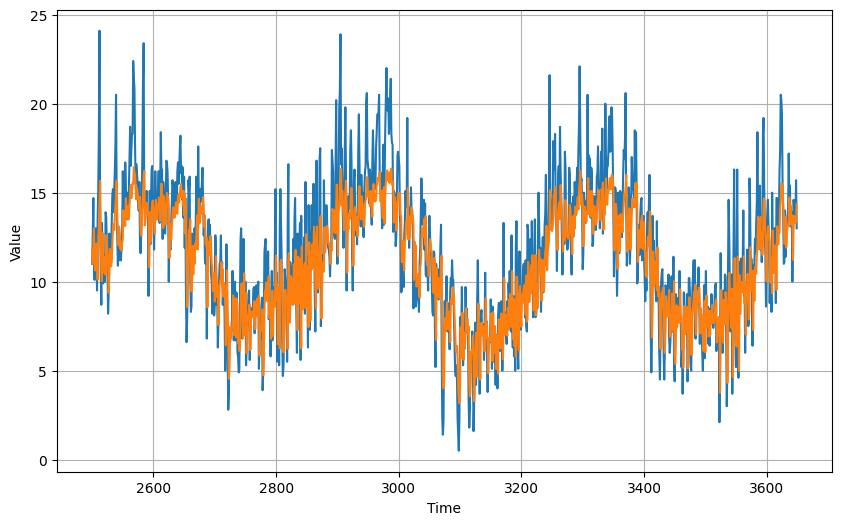

In [62]:
# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [63]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.76, mae: 1.87 for forecast


**To pass this assignment your forecast should achieve a MSE of 6 or less and a MAE of 2 or less.**

If your forecast didn't achieve this threshold try re-training your model with a different architecture (you will need to re-run both `create_uncompiled_model` and `create_model` functions) or tweaking the optimizer's parameters.

If your forecast did achieve these thresholds run the following cell to save the metrics in a binary file which will be used for grading. After doing so, submit your assignment for grading.

In [64]:
# Save metrics into a dictionary
metrics_dict = {
    "mse": float(mse),
    "mae": float(mae)
}

# Save your metrics in a binary file 
with open('metrics.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f)

**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of forecasting time series leveraging a combination of Tensorflow's layers such as Convolutional and LSTMs! This resulted in a forecast that surpasses all the ones you did previously.

**By finishing this assignment you have finished the specialization! Give yourself a pat on the back!!!**